- DATA: Machine Learning Housing Corp.! 
- TASK: to predict median house values in Californian districts, given a number of features from these districts.

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

A Quick Look at the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


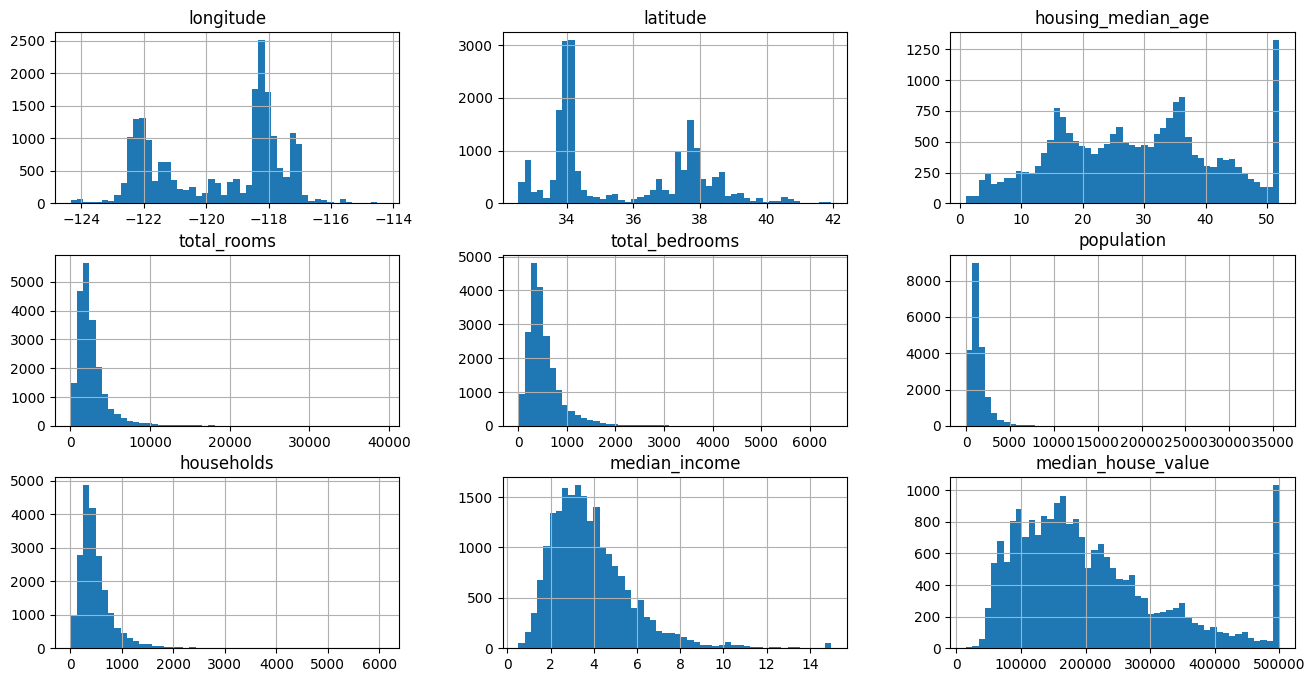

In [7]:
# another quick way to get a feel of data is to plot a histogram for each numerical attribute

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(16,8))
plt.show()

### **Feature Distributions**

We can immediately see the **shape** of the data for each numerical feature:

* **Normal (bell-shaped)**: e.g., `median_income` may look skewed right.
* **Uniform**: evenly spread (uncommon in real-world data).
* **Skewed**: long tail on one side (common in income, house value, etc.).
* **Bimodal** or multimodal: more than one peak.

---

### **Skewness and Outliers**

* **Right-skewed** features (long tail on the right) — e.g., `median_income`, `households`.
* **Extreme outliers** — unusually high values, like in `total_rooms` or `population`.
* Features with **logarithmic or exponential-like distributions**.

---

### **Uneven Distributions**

* For features like `median_house_value`, you might notice a **sharp cutoff at 500,000** — this is due to a **data cap** in the original dataset.
* Important to handle this carefully — can **bias training** if not treated properly.

---

### Summary of Insights from Histogram Plots

| Observation                     | What It Tells You                      |
| ------------------------------- | -------------------------------------- |
| Skewed distributions            | Apply transformations (log, sqrt)      |
| Outliers                        | May need clipping or special handling  |
| Sharp cutoffs                   | Data limitations or caps               |
| Discrete spikes in numeric data | Feature may be categorical or bucketed |
| Uneven scales                   | Normalize or standardize features      |
| Missing/placeholder values      | Need data cleaning                     |


In [8]:
import numpy as np

# 1. Create income categories
housing["income_category"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

# 2. Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# 3. Drop income_category (optional column)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

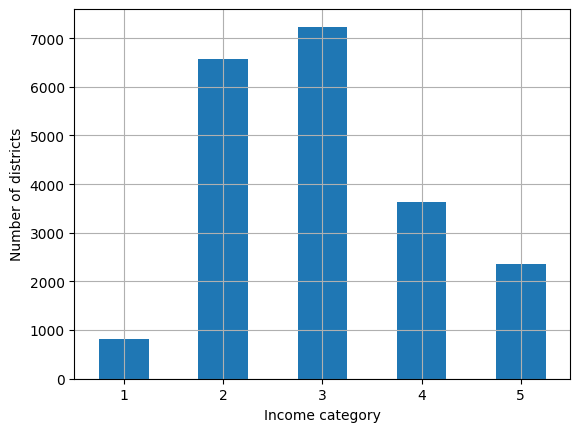

In [9]:
# income categories representation
housing['income_category'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Number of districts')
plt.show()

In [10]:
# since we're going to experiment with various transformations of the full training set, we should make a copy of the original so you can revert to it afterwards
housing = strat_train_set.copy()